# Section 5.1 — Introduction to Bayesian statistics

This notebook contains the code examples from [Section 5.1 Introduction to Bayesian statistics]() from the **No Bullshit Guide to Statistics**.

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn"t work
from plot_helpers import RCPARAMS
RCPARAMS.update({"figure.figsize": (5, 3)})   # good for screen
# RCPARAMS.update({"figure.figsize": (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = "retina"

# Where to store figures
from ministats.utils import savefigure
DESTDIR = "figures/bayes/intro"

#######################################################

<Figure size 640x480 with 0 Axes>

## Definitions

### Data model and likelihood function
### Parameters distributions
### Bayesian model
### Calculating the posterior distribution

### Bayesian inference results

#### Visualizing the posterior

Saved figure to figures/bayes/intro/posterior_visualization.pdf
Saved figure to figures/bayes/intro/posterior_visualization.png


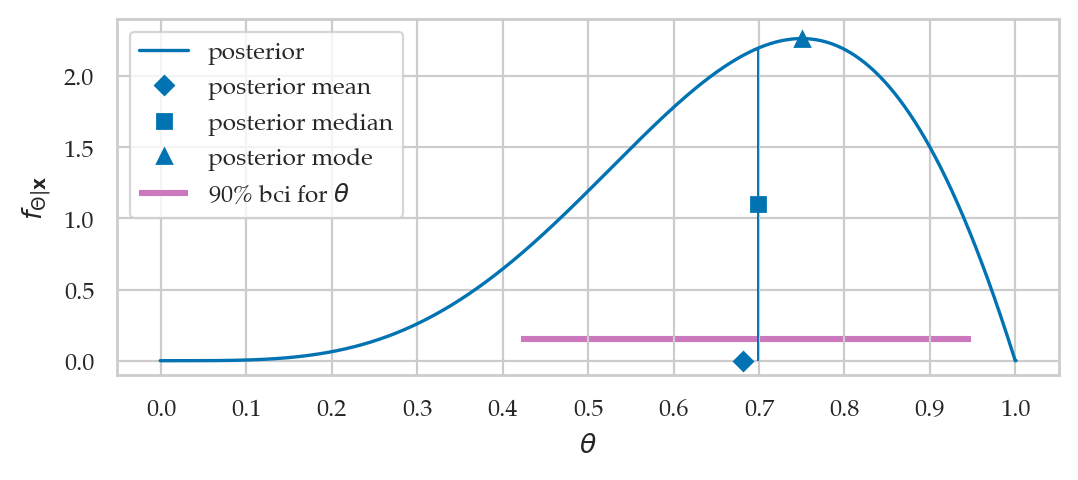

In [5]:
from ministats.plots.figures import posterior_visualization
# posterior_visualization(heads=4, n=5)

# FIGURES ONLY
posterior_visualization(heads=4, n=5, destdir=DESTDIR)

#### Point estimates

- posterior mean
- posterior median
- posterior mode

#### Bayesian credible interval

- $(1-\alpha)$ high probability density interval


#### Bayesian predictions

- draws form the posterior predictive distribution

#### Bayesian hypothesis testing

TODO

## Bayesian inference

TODO: add explanations and formulas

### Bayesian updating of posterior probabilities

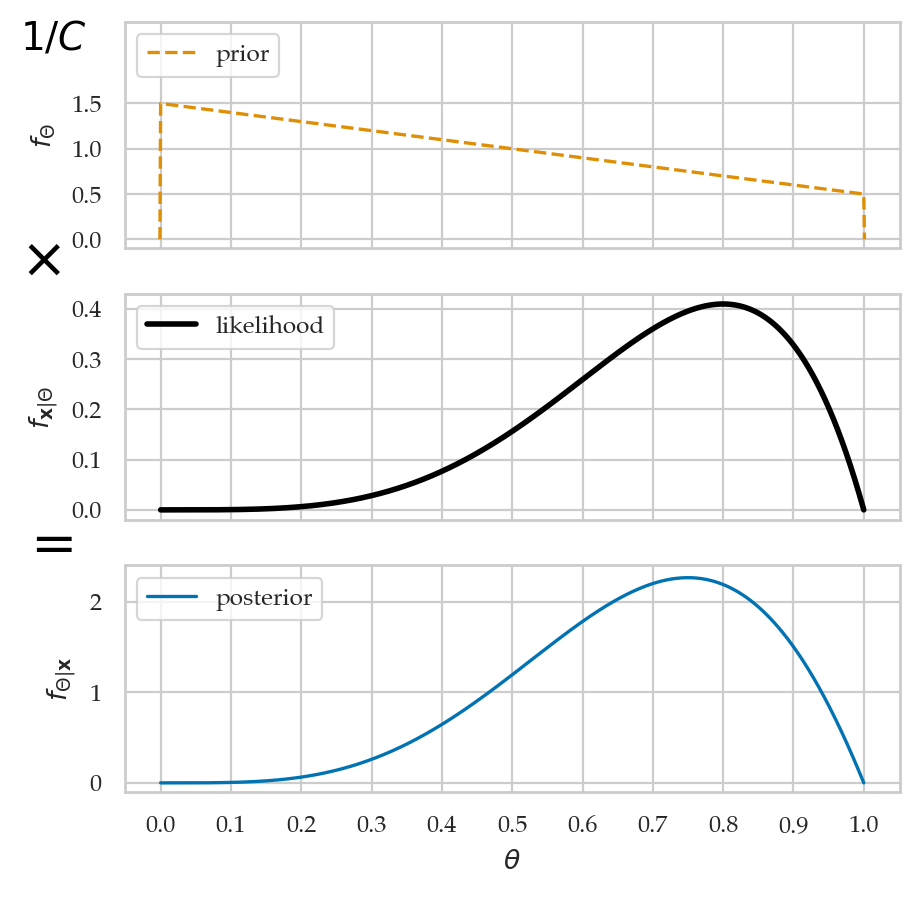

In [3]:
from ministats.plots.figures import prior_times_likelihood_eq_posterior
prior_times_likelihood_eq_posterior(heads=4, n=5)

# FIGURES ONLY
# prior_times_likelihood_eq_posterior(heads=4, n=5, destdir=DESTDIR);

### Grid approximation


TODO: add explanations and formulas

TODO: add steps

Pseudocode:


```Python
prior_rv = ... # specify the prior distribtion
model = ...    # specify the data model

# 1. Define the grid of possible parameter values
thetas = [0, 0.05, 0.10, 0.15, ..., 1.0]

# 2. Evaluate the prior distribution for all thetas
prior = [prior_rv.pdf(th) for th in thetas]

# 3. Compute the likelihood of the data for all thetas
likelihood = [model(th).pdf(data) for th in thetas]

# 4. Calculate the numerator in Bayes' formula
numerator = np.multiply(likelihood, prior)

# 5. Normalize to obtain the posterior distribution
posterior = numerator / np.sum(numerator)
```


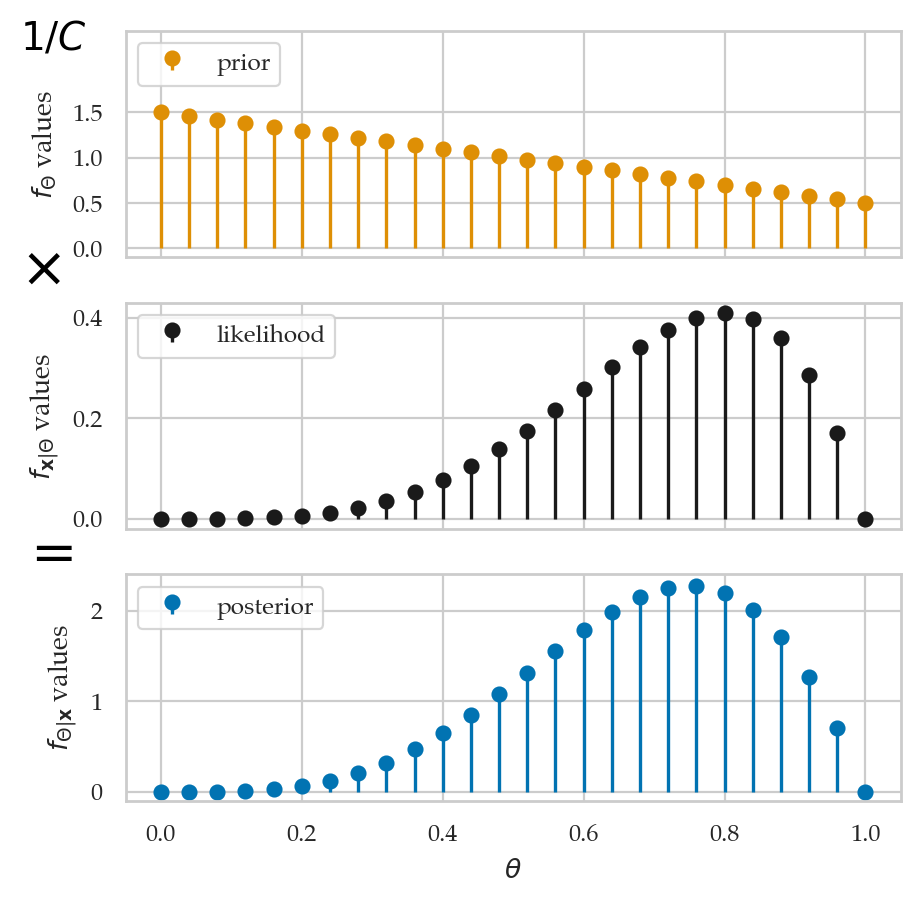

In [4]:
from ministats.plots.figures import prior_times_likelihood_eq_posterior_grid
prior_times_likelihood_eq_posterior_grid(heads=4, n=5)

# FIGURES ONLY
# prior_times_likelihood_eq_posterior_grid(heads=4, n=5, destdir=DESTDIR)

## Example 1: estimating the probability of a biased coin

Suppose we're given a biased coin
and we want to estimate the probability the coin turns up heads.

### Data

We have a sample $\mathbf{c} = \texttt{ctosses}$ that contains $n=50$ observations (coin tosses) from the coin.
The outcome `1` corresponds to heads,
while the outcome `0` corresponds to tails.

In [6]:
ctosses = [1,1,0,0,1,0,1,1,1,1,1,0,1,1,0,0,0,1,1,1,
           1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,0,1,0,
           0,1,0,1,0,1,0,1,1,0]

sum(ctosses), len(ctosses), sum(ctosses)/len(ctosses)

(34, 50, 0.68)

### Model

The Bayesian model for the coin tosses is
describe by the Bernoulli distribution with a uniform prior on the parameter:

$$
    C \sim \textrm{Bernoulli}(P),
    \qquad
    P \sim \mathcal{U}(0,1).
    \qquad
$$

To estimate the parameter $P$,
we'll use the Bayesian inference
following the five-step grid approximation procedure.

### Step 1: define a grid of possible parameter values

We start by defining a grid for the  possible values for the parameter $P$.
We'll cover the interval from $0$ to $1$ using a grid with 100 steps.

In [7]:
ngrid1 = 101             # number of points in the grid
ps = np.linspace(0, 1, ngrid1) # [0, 0.01, ..., 1.0]
ps[0:5]

array([0.  , 0.01, 0.02, 0.03, 0.04])

### Step 2: define a flat prior distribution

In [8]:
from scipy.stats import uniform
prior1 = uniform(0,1).pdf(ps)
prior1[0:5]

array([1., 1., 1., 1., 1.])

### Step 3: compute the likelihood

Next we want to compute the likelihood of the data $\tt{ctosses} = \mathbf{c} = [c_1,c_2,\ldots,c_{50}]$
according to the model $f_{C|P}(c|p) = p^c(1-p)^{1-c}$.

Recall that the likelihood function is the product of the probabilities
for individual observations

\begin{align*}
  f_{\mathbf{c}|P}(\mathbf{c}|p) 
    &= f_{C|P}(c_1|p) \, f_{C|P}(c_2|p)  \, \cdots  \, f_{C|P}(c_{50}|p)  \\
    &= p^{c_1}(1-p)^{1-{c_1}}  \,  p^{c_2}(1-p)^{1-{c_2}} \cdots \, p^{c_{50}} (1-p)^{1-c_{50}}  \\
    &= p^{\sum_i^n c_i} (1-p)^{n-\sum_i^n c_i} \\
    &= p^{y} (1-p)^{n-y},
\end{align*}

where we have defined $y = \sum_i^n c_i$ the total number of heads in the data $\tt{ctosses} = \mathbf{c}$.

We can use now use this formula to calculate the likelihood of the data
for all the values of the parameters $P$ in the grid `ps`.

In [9]:
y = sum(ctosses)
n = len(ctosses)
likelihood1 = ps**y * (1-ps)**(n-y)

likelihood1[0:101:25]
# list(map(lambda x: float("{:1.3g}".format(x)), likelihood1[0:101:25]))  # CUTME

array([0.00000000e+00, 3.39578753e-23, 8.88178420e-16, 1.31559767e-14,
       0.00000000e+00])

### Step 4: calculate the numerator in Bayes' formula

Next we multiply the likelihood and the prior to obtain the numerator of the Bayes' rule formula.

In [10]:
numerator1 = likelihood1 * prior1

numerator1[0:101:25]
# list(map(lambda x: float("{:1.3g}".format(x)), numerator1[0:101:25]))  # CUTME

array([0.00000000e+00, 3.39578753e-23, 8.88178420e-16, 1.31559767e-14,
       0.00000000e+00])

### Step 5: normalize to obtain the posterior distribution

The final step is to make sure the posterior is a valid probability distribution.

In [11]:
posterior1 = numerator1 / np.sum(numerator1)

posterior1[0:101:25]
# list(map(lambda x: float("{:1.3g}".format(x)), posterior1[0:101:25]))  # CUTME

array([0.00000000e+00, 8.52710007e-11, 2.23028862e-03, 3.30357328e-02,
       0.00000000e+00])

We can verify that the sum of the values in the array `posterior1` is $1$.

In [12]:
np.sum(posterior1).round(15)

1.0

### Visualizing the posterior

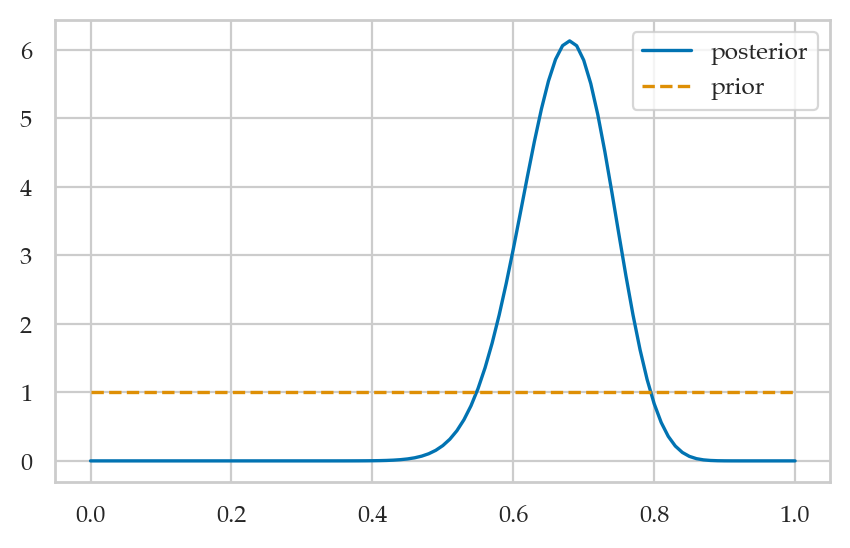

In [13]:
posterior1d = posterior1 / (ps[1] - ps[0])
sns.lineplot(x=ps, y=posterior1d, label="posterior")
sns.lineplot(x=ps, y=prior1, ls="--", label="prior");

Saved figure to figures/bayes/intro/example1_ctosses_prior_and_posterior.pdf
Saved figure to figures/bayes/intro/example1_ctosses_prior_and_posterior.png


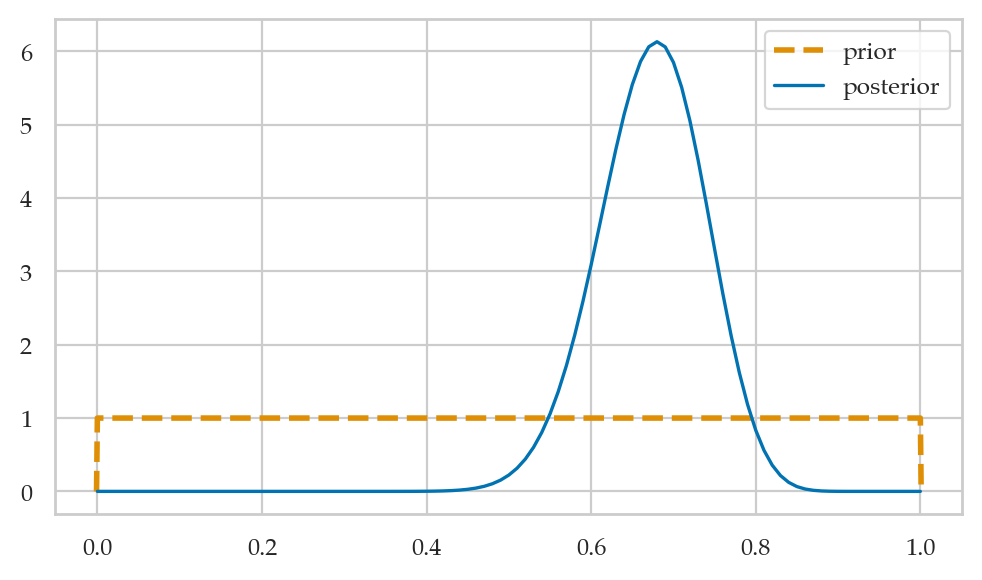

In [14]:
# FIGURES ONLY
psplus = [-0.001] + list(ps) + [1.001]
prior1plus = [0] + list(prior1) + [0]
sns.lineplot(x=psplus, y=prior1plus, ls="--", linewidth=2, label="prior", color="C1");
sns.lineplot(x=ps, y=posterior1d, label="posterior", color="C0")

filename = os.path.join(DESTDIR, "example1_ctosses_prior_and_posterior.pdf")
savefigure(plt.gcf(), filename)

### Summarize the posterior

#### Posterior mean

In [15]:
postmu1 = np.sum(ps * posterior1)
postmu1

0.673076923076923

#### Posterior standard deviation

In [16]:
poststd1 = np.sqrt(np.sum((ps-postmu1)**2*posterior1))
poststd1

0.06443431329777005

#### Posterior median

In [17]:
cumsum1 = np.cumsum(posterior1)
idxMed = cumsum1.searchsorted(0.5)
ps[idxMed]

0.68

#### Posterior quartiles

In [18]:
idxQ1 = cumsum1.searchsorted(0.25)
idxQ2 = cumsum1.searchsorted(0.5)
idxQ3 = cumsum1.searchsorted(0.75)
ps[idxQ1], ps[idxQ2], ps[idxQ3]

(0.63, 0.68, 0.72)

#### Posterior percentiles

In [19]:
idxP03 = cumsum1.searchsorted(0.03)
idxP97 = cumsum1.searchsorted(0.97)
ps[idxP03], ps[idxP97]

(0.55, 0.79)

#### Posterior mode

In [20]:
ps[np.argmax(posterior1)]

0.68

### Credible interval

In [21]:
from ministats.hpdi import hpdi_from_grid
hpdi_from_grid(ps, posterior1, hdi_prob=0.9)

[0.54, 0.76]

### Predictions

In [22]:
np.random.seed(43)

from scipy.stats import bernoulli

ctoss_preds = []
for i in range(20):
    p_post = np.random.choice(ps, p=posterior1)
    ctoss_pred = bernoulli(p=p_post).rvs(1)[0]
    ctoss_preds.append(ctoss_pred)
ctoss_preds

[0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1]

### Visualizing the posterior updates over time

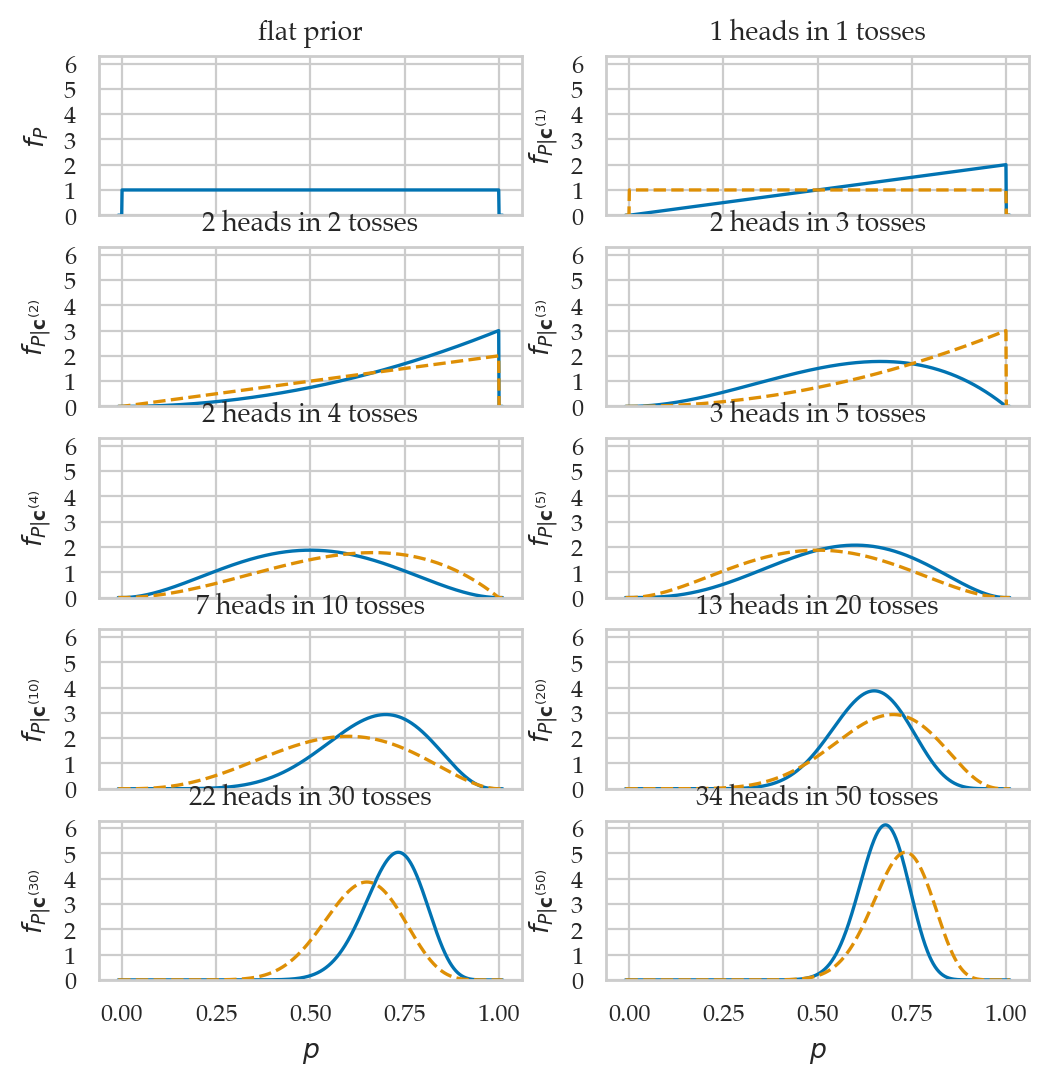

In [23]:
from ministats.plots.figures import panel_coin_posteriors
panel_coin_posteriors()

# FIGURES ONLY
# panel_coin_posteriors(destdir=DESTDIR)

## Example 2: estimating the IQ score

Suppose we're investigating the effect of a new smart drug.
We give the drug to a sample of $30$ individuals who are representative of the population,
then make them take an IQ test.

### Data

We have a sample of $n=30$ IQ measurements from people who took the smart drug.

In [24]:
iqs = [ 82.6, 105.5,  96.7,  84.0, 127.2,  98.8,  94.3,
       122.1,  86.8,  86.1, 107.9, 118.9, 116.5, 101.0,
        91.0, 130.0, 155.7, 120.8, 107.9, 117.1, 100.1,
       108.2,  99.8, 103.6, 108.1, 110.3, 101.8, 131.7,
       103.8, 116.4]

### Model

We will use the following Bayesian model:

$$
    X \sim \mathcal{N}(M, \sigma=15),
    \qquad
    M \sim \mathcal{N}(\mu_M=100,\sigma_M=40).
$$

We place a broad prior on the mean parameter $M$,
by choosing a large value for the standard deviation $\sigma_M$.
We assume the IQ scores come from a population with known standard deviation $\sigma = 15$.

### Step 1: define a grid of possible values of the mean

This time we'll use a finer grid with 1000 steps.
The parameter space for the mean of a normal distribution is infinite $(-\infty, \infty)$,
so we can't define a grid that covers the whole parameter space.
Instead,
we'll define a grid that cover only the most likely values for the mean,
which is a window of $\pm 20$ around the mean of the wider population.

In [25]:
ngrid2 = 1001  # number of points in the grid
mus = np.linspace(80, 120, ngrid2)
mus[0:5]

array([80.  , 80.04, 80.08, 80.12, 80.16])

### Step 2: define the prior for the unknown mean

We define a normal distribution centered at $\mu_M=100$ with standard deviation $\sigma_M=40$,
then evaluate it for each point in the grid `mus`.

In [26]:
from scipy.stats import norm

mu_M = 100
sigma_M = 40
prior2 = norm(loc=mu_M, scale=sigma_M).pdf(mus)

prior2[0:1001:300]
# list(map(lambda x: float("{:1.3g}".format(x)), prior2[0:1001:300]))  # CUTME

array([0.00880163, 0.00977607, 0.00992381, 0.00920675])

### Step 3: compute the likelihood of the data

TODO: show formula

TODO: explain iterative calculation

In [27]:
sigma = 15  # known population standard deviation

likelihood2 = np.ones(ngrid2)
for iq in iqs:
    likelihood_iq = norm(loc=mus, scale=sigma).pdf(iq)
    likelihood2 = likelihood2 * likelihood_iq

likelihood2[0:1001:300]
# list(map(lambda x: float("{:1.3g}".format(x)), likelihood2[0:1001:300]))  # CUTME

array([1.23613569e-77, 1.80497559e-62, 1.20898934e-55, 3.71466415e-57])

### Steps 4: calculate the numerator in Bayes' rule formula

In [28]:
numerator2 = likelihood2 * prior2

numerator2[0:1001:300]
# list(map(lambda x: float("{:1.3g}".format(x)), numerator2[0:1001:300]))  # CUTME

array([1.08800129e-79, 1.76455630e-64, 1.19977849e-57, 3.41999972e-59])

### Steps 5: normalize to obtain the posterior distribution

In [29]:
posterior2 = numerator2 / np.sum(numerator2)

posterior2[0:1001:300]
# list(map(lambda x: float("{:1.3g}".format(x)), posterior2[0:1001:300]))  # CUTME

array([2.02698373e-25, 3.28742893e-10, 2.23522850e-03, 6.37157683e-05])

### Visualizing the posterior

Saved figure to figures/bayes/intro/example2_iq_prior_and_posterior.pdf
Saved figure to figures/bayes/intro/example2_iq_prior_and_posterior.png


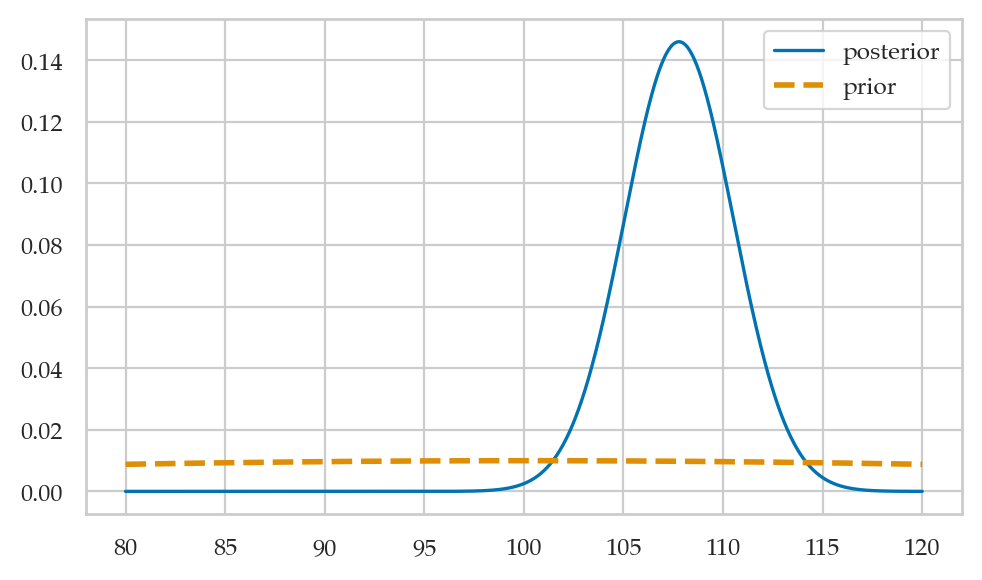

In [30]:
posterior2d = posterior2 / (mus[1] - mus[0])
sns.lineplot(x=mus, y=posterior2d, label="posterior")
sns.lineplot(x=mus, y=prior2, ls="--", linewidth=2, label="prior");

# FIGURES ONLY
filename = os.path.join(DESTDIR, "example2_iq_prior_and_posterior.pdf")
savefigure(plt.gcf(), filename)

### Summarize the posterior

#### Posterior mean

In [31]:
postmu2 = np.sum(mus * posterior2)
postmu2

107.78678422532585

#### Posterior standard deviation

In [32]:
poststd2 = np.sqrt(np.sum((mus-postmu2)**2*posterior2))
poststd2

2.7321084402431834

#### Posterior median

In [33]:
cumsum2 = np.cumsum(posterior2)
mus[cumsum2.searchsorted(0.5)]

107.8

#### Posterior mode

In [34]:
mus[np.argmax(posterior2)]

107.8

### Credible interval for the mean

In [35]:
from ministats.hpdi import hpdi_from_grid
hpdi_from_grid(mus, posterior2, hdi_prob=0.9)

[103.16, 112.16]

Let's compare the Bayesian credible interval to the frequentist confidence interval.

In [36]:
from ministats import ci_mean
ci_mean(iqs, method="a", alpha=0.1)

[102.83429390645762, 112.81237276020906]

### Predictions

In [37]:
np.random.seed(43)

sigma = 15  # known population standard deviation

iq_preds = []
for i in range(7):
    mu_post = np.random.choice(mus, p=posterior2)
    iq_pred = norm(loc=mu_post, scale=sigma).rvs(1)[0]
    iq_preds.append(iq_pred)
np.round(iq_preds, 2)

array([ 89.64, 110.31, 112.65, 121.25,  92.55, 132.49,  98.97])

### Hypothesis test

Consider the null hypothesis $H_0: \mu=100$.
We can informally reject this hypothesis,
since the value $\mu=100$ is outside the 90\% credible interval.

We can also compute the total probability of in the posterior that is equal to or smaller than $\mu=100$.

In [38]:
mu100 = mus.searchsorted(100)
np.sum(posterior2[0:mu100])

0.0021359730162427413

We see the probability of $\mu=100$ or smaller is around $0.21\%$,
which gives us reason to reject $H_0$.

This conclusion is consistent with the conclusion of the frequentist one-sample $t$-test,
which leads us to reject $H_0$.

In [39]:
from scipy.stats import ttest_1samp
tt_res = ttest_1samp(iqs, 100, alternative="greater")
tt_res.statistic, tt_res.pvalue

(2.664408108831371, 0.006232014580899188)

## Explanations

### Grid approximation details

### Choosing priors

In [40]:
# TODO: move this code to `ministats.bayes`

from ministats.hpdi import hpdi_from_grid

def get_post_mean_stats(sample, sigma=15, prior_rv=None, ngrid=10001, xlims=[70,130],
                       stats=["mean", "median", "mode", "bci90"]):
    mus = np.linspace(*xlims, ngrid)
    prior = prior_rv.pdf(mus)
    likelihoodsM = norm(loc=mus[:,np.newaxis], scale=sigma).pdf(sample)
    likelihood = np.prod(likelihoodsM, axis=1)
    numerator = likelihood * prior
    posterior = numerator / np.sum(numerator) 

    # compute stats
    results = {}
    if "mean" in stats:
        post_mean = np.sum(mus * posterior)
        results["post mean"] = post_mean
    if "median" in stats:
        cumsum = np.cumsum(posterior)
        post_median = mus[cumsum.searchsorted(0.5)]
        results["post median"] = post_median
    if "mode" in stats:
        post_mode = mus[np.argmax(posterior)]
        results["post mode"] = post_mode
    if "bci90" in stats:
        ci90 = hpdi_from_grid(mus, posterior, hdi_prob=0.9)
        results["bci90"] = [ci90[0].round(3), ci90[1].round(3)]
    if "prob_lt_100" in stats:
        idx100 = mus.searchsorted(100)
        prob_lt_100 = np.sum(posterior[0:idx100])
        results["prob_lt_100"] = prob_lt_100
    return results

In [41]:
# frequentist summary
from ministats import ci_mean
np.mean(iqs), ci_mean(iqs, alpha=0.1)

(107.82333333333334, [102.83429390645762, 112.81237276020906])

Saved figure to figures/bayes/intro/different_priors_for_example2.pdf
Saved figure to figures/bayes/intro/different_priors_for_example2.png


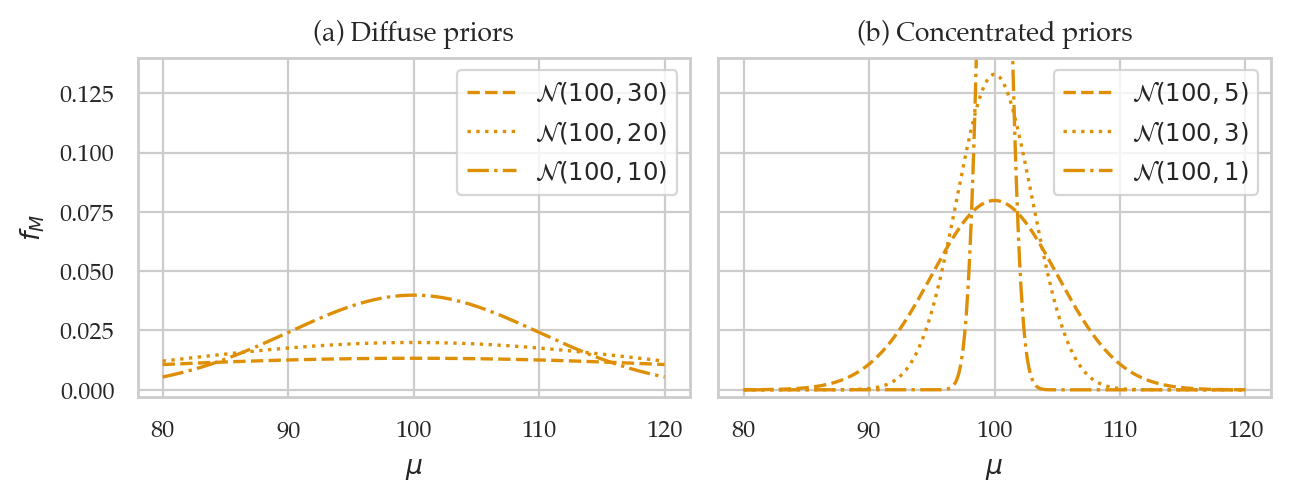

In [42]:
from ministats import plot_pdf

priors = [
    norm(loc=100, scale=40),
    # varying mu_M
    norm(loc=80,  scale=40),
    norm(loc=50,  scale=40),
    norm(loc=0,   scale=40),
    # varying sigma_M
    norm(loc=100, scale=30),
    norm(loc=100, scale=20),
    norm(loc=100, scale=10),
    norm(loc=100, scale=5),
    norm(loc=100, scale=3),
    norm(loc=100, scale=1),
]

def get_label(prior):
    mu = str(prior.kwds["loc"])
    sigma = str(prior.kwds["scale"])
    return r"$\mathcal{N}(" + mu + "," + sigma + ")$"


linestyles = ["dashed", "dotted", "dashdot", (5, (10, 3))]
xlims = [80,120]

with plt.rc_context({"figure.figsize":(6.5,2.6)}):
    fig, (ax1,ax2) = plt.subplots(1,2, sharey=True)
    for prior, ls in zip(priors[4:7], linestyles):
        plot_pdf(prior, ax=ax1, ls=ls, color="C1", xlims=xlims, label=get_label(prior))
    for prior, ls in zip(priors[7:], linestyles):
        plot_pdf(prior, ax=ax2, ls=ls, color="C1", xlims=xlims, label=get_label(prior))
    ax1.set_ylim(-0.003, 0.14)
    ax1.set_xlabel(r"$\mu$")
    ax1.set_ylabel(r"$f_M$")
    ax1.set_title("(a) Diffuse priors")
    ax2.set_xlabel(r"$\mu$")
    ax2.set_title("(b) Concentrated priors")

    # FIGURES ONLY
    filename = os.path.join(DESTDIR, "different_priors_for_example2.pdf")
    savefigure(plt.gcf(), filename)

In [43]:
# TODO: move this code to `ministats.book.tables`

results_list = []
for prior in priors:
    stats = get_post_mean_stats(iqs, prior_rv=prior)
    result = prior.kwds.copy()
    stats["bci90"] = [np.round(stats["bci90"][0], 2), np.round(stats["bci90"][1], 2)]
    result.update(stats)
    results_list.append(result)

results = pd.DataFrame(results_list)
results = results.round({"post mean":2, "post median":2, "post mode":2, "prob_lt_100":5})
results
# print(results.to_latex(index=False,formatters=[lambda x: "$" + str(x) + "$"]*7))

,loc,scale,post mean,post median,post mode,bci90
0,100,40,107.79,107.79,107.79,"[103.19, 112.19]"
1,80,40,107.69,107.69,107.69,"[103.1, 112.09]"
2,50,40,107.55,107.55,107.55,"[102.96, 111.95]"
3,0,40,107.32,107.32,107.32,"[102.72, 111.72]"
4,100,30,107.76,107.76,107.76,"[103.19, 112.16]"
5,100,20,107.68,107.68,107.68,"[103.16, 112.08]"
6,100,10,107.28,107.28,107.28,"[102.86, 111.56]"
7,100,5,106.02,106.02,106.02,"[102.05, 109.95]"
8,100,3,104.27,104.27,104.27,"[100.92, 107.58]"
9,100,1,100.92,100.92,100.92,"[99.32, 102.41]"


## Bayesian hypothesis testing

Suppose we want to evaluate whether the IQ data measurements `iqs`
comes from a population with a mean $\mu_0=100$ or not,
which corresponds to the null hypothesis (the smart drug was not effective).

### Bayesian model comparison

In Bayesian model comparison,
we want compare the *posterior probability distributions* of two models:

The null hypothesis is $H_0: \mu = \mu_0 = 100$
while the alternative hypothesis $H_1: \mu \neq 100$.
Actually,
we need to be more specific and show the full Bayesian model under each distribution:

Under H0

...


Under H1

...


### Bayes factors

TODO: show formulas

#### Test 1: using a point null and Cauchy on effect size

In [44]:
# under H0 = point-prior at mu=100
from scipy.stats import norm

sigma = 15  # known population standard deviation
mlikelihood_H0 = np.prod(norm(loc=100, scale=sigma).pdf(iqs))
mlikelihood_H0

5.415023175654286e-57

We'll set a prior on the effect size $\Delta = \mu / \sigma$,
using the Cauchy distribution (very fat tails).

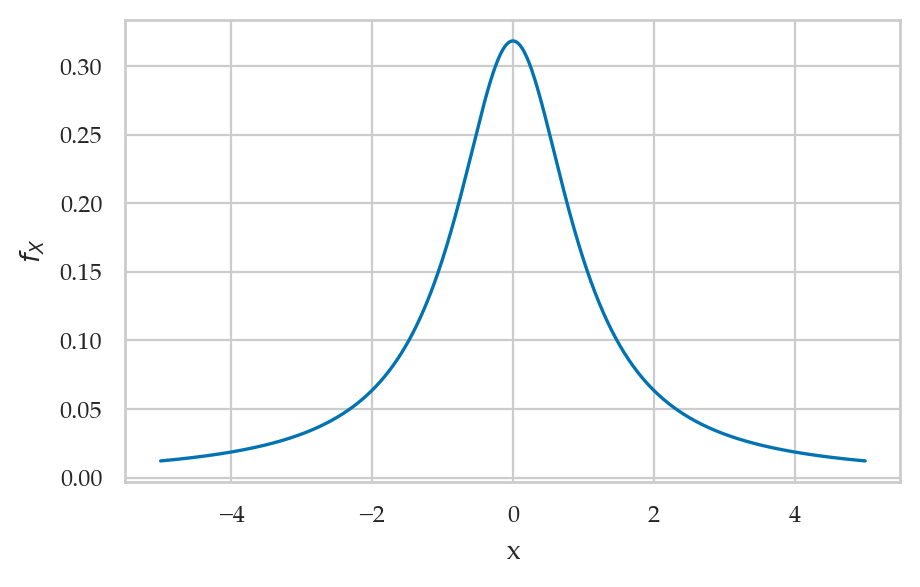

In [45]:
from scipy.stats import cauchy

r = 1  # scale for the Cauchy prior
plot_pdf(cauchy(scale=r), xlims=[-5,5]);

In [46]:
from scipy.integrate import quad

r = 1  # scale for the Cauchy prior
prior_delta = cauchy(scale=r)
delta_max = 10

def integrand(delta):
    # Convert delta into the mean under H1: mu = 100 + delta * sigma
    mu = 100 + delta * sigma
    # Likelihood as the product of normal densities for each observation
    likelihood = np.prod(norm(loc=mu, scale=sigma).pdf(iqs))
    prior = cauchy(loc=0, scale=r).pdf(delta)
    return likelihood * prior

mlikelihood_HA, _ = quad(integrand, -delta_max, delta_max)
print(mlikelihood_HA)

simple_BF_A0 = mlikelihood_HA / mlikelihood_H0
simple_BF_A0

3.647361365721922e-56


6.7356338974139645

In [47]:
mugrid = np.linspace(-50, 250, 1001)

# under HA = diffuse prior
deltas = (mugrid-100) / sigma

prior_rv = cauchy(scale=r) 
prior = prior_rv.pdf(deltas)
norm_const = prior_rv.cdf(10) - prior_rv.cdf(-10)
prior = prior / np.sum(prior) * norm_const

likelihood_HA = np.prod(norm(loc=mugrid[:,np.newaxis], scale=sigma).pdf(iqs), axis=1)
mlikelihood_HA_alt = np.sum(likelihood_HA * prior)
print(mlikelihood_HA_alt)

simple_BF_A0_alt = mlikelihood_HA_alt / mlikelihood_H0
simple_BF_A0_alt

3.649465841847485e-56


6.739520263284058

#### Test 2: using the default Jeffrey-Zellner-Siow (JZS) prior

$$
  H_0: \mu = 100,
  \qquad
  H_A: \frac{\mu - 100}{\sigma} \sim \textrm{Cauchy}(r),
  \sigma \sim \textrm{Jeffreys}
$$

In [48]:
# TODO: move this code to `ministats.bayes`

import numpy as np
from scipy.stats import norm, cauchy
from scipy.integrate import quad

# finite integration limits to avoid `np.inf`
simgma_max = 50
delta_max = 10

# Known mean under H0
mu_0 = 100

# Scale parameter under H1
r = 0.707  # scale for the Cauchy prior


# Define the marginal likelihood under H0 using Jeffreys prior for sigma
def marginal_likelihood_H0(iqs, mu_0):
    """
    Marginal likelihood under H0 with Jeffreys prior for sigma.
    """
    def integrand(sigma):
        # Likelihood as the product of normal densities for each observation
        likelihood = np.prod(norm.pdf(iqs, loc=mu_0, scale=sigma))
        # ALT.
        # likelihood = np.prod([norm.pdf(iq, loc=mu_0, scale=sigma) for iq in iqs])
        prior = 1 / sigma  # Jeffrey's prior for sigma
        return likelihood * prior

    result, _ = quad(integrand, 0, simgma_max) # limit=1000)
    return result

m0 = marginal_likelihood_H0(iqs, mu_0)
# print(m0)


# Define the marginal likelihood under H1, integrating over delta and sigma
def marginal_likelihood_HA(iqs, mu_0):
    """
    Marginal likelihood under H1 integrating over delta and sigma.
    """
    def integrand(delta, sigma):
        # Convert delta into the mean under H1: mu = mu_0 + delta * sigma
        mu = mu_0 + delta * sigma
        # Likelihood as the product of normal densities for each observation
        likelihood = np.prod(norm.pdf(iqs, loc=mu, scale=sigma))
        # ALT.
        # likelihood = np.prod([norm.pdf(iq, loc=mu, scale=sigma) for iq in iqs])
        prior_delta = cauchy(loc=0, scale=r).pdf(delta)
        prior_sigma = 1 / sigma  # Jeffrey's prior for sigma
        return likelihood * prior_delta * prior_sigma

    # Inner integral sigma for a given delta
    def integrate_delta(delta):
        return quad(lambda sigma: integrand(delta, sigma), 0, simgma_max)[0]

    # Outer integral over delta
    result, _ = quad(integrate_delta, -delta_max, delta_max)
    return result

mA = marginal_likelihood_HA(iqs, mu_0)
# print(mA)

# Compute the Bayes factor
BF_A0 = mA / m0

print(f"Bayes Factor (BF_A0): {BF_A0}")

Bayes Factor (BF_A0): 3.720150734157744


In [49]:
# Bayes factor (based on JZS prior)
import pingouin as pg
pg.ttest(iqs, 100).loc["T-test","BF10"]

'3.74'

In [50]:
# ALT. Bayes factor (based on JZS prior)
n = len(iqs)
tstat = (np.mean(iqs) - 100) / np.std(iqs, ddof=1) * np.sqrt(n)
pg.bayesfactor_ttest(tstat, nx=n)

3.7397058298821895

In [51]:
# TODO: sensitivity analysis
# plot BF for multiple values of r

In [52]:
# Compare to the frequentist result
from scipy.stats import ttest_1samp
ttest_1samp(iqs, popmean=100)

TtestResult(statistic=2.664408108831371, pvalue=0.012464029161798377, df=29)

### Using credible intervals for decisions

In [53]:
bci95 = hpdi_from_grid(mus, posterior2, hdi_prob=0.95)
bci95

[102.32, 113.03999999999999]

In [54]:
bci99 = hpdi_from_grid(mus, posterior2, hdi_prob=0.99)
bci99

[100.68, 114.75999999999999]

### Region of practical equivalence

In [55]:
mu97 = mus.searchsorted(97)
mu103 = mus.searchsorted(103)
np.sum(posterior2[mu97:mu103+1])

0.040481237454239115

## Discussion

### Maximum a posteriori estimates

### Comparing Bayesian and frequentist approaches to statistical inference

### Strengths and weaknesses of Bayesian approach

### Sampling from the posterior (BONUS TOPIC)

We'll now show how to analyze the Bayesian analysis
when the posterior distribution
is available in the form of samples.
This will be the form of analysis in all the future sections of the chapter,
so I thought I can give you a little preview.

We start by generating some samples from the posterior distribution
we obtained in Example 2.

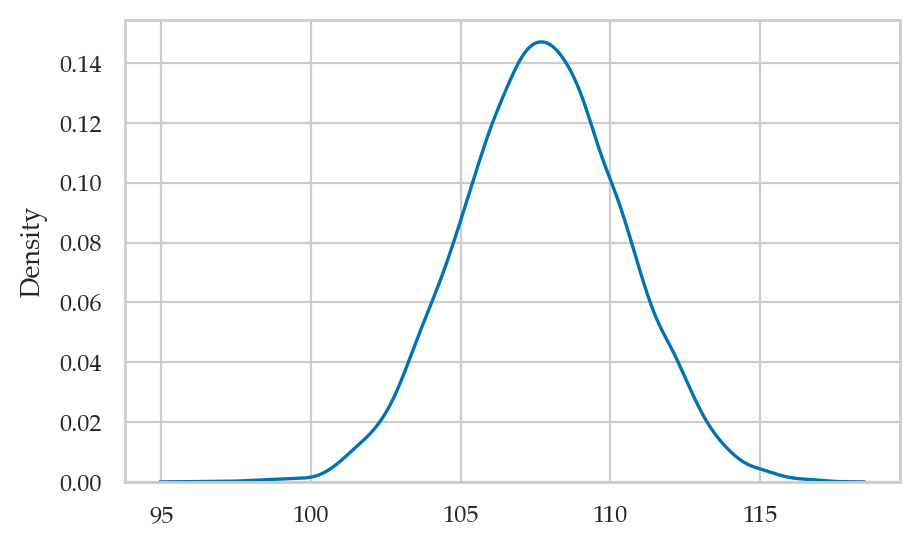

In [56]:
np.random.seed(42)
postM = np.random.choice(mus, size=10000, replace=True, p=posterior2)
sns.kdeplot(postM);

#### Posterior mean

To compute the mean of the posterior,
we compute the mean  of the samples.

In [57]:
postMmu = np.mean(postM)
postMmu

107.73182

In the next seciton,
we'll also learn about the ArviZ library,
which is a Swiss Army knife for for summarizing, visualizing, and plotting the Bayesian analysis results.
For example,
we can obtain the mean using the `summary` function from the ArviZ library.

In [58]:
import arviz as az
az.summary(postM, kind="stats")

,mean,sd,hdi_3%,hdi_97%
x,107.732,2.712,102.76,112.84


The summary also includes the posterior standard deviation
and the limits of a "94\% high density interval" that contains 94\% of the posterior probability density.

#### Posterior standard deviation

To compute the standard deviation of the posterior,
we compute the standard deviation of the samples.

In [59]:
np.sqrt(np.sum((postM-postMmu)**2) / len(postM))

2.712109726320084

#### Posterior median

To compute the median of the posterior,
we compute the median of the samples.

In [60]:
np.median(postM)

107.72

We can also obtain median using the ArviZ `summary` function,
if we specify the `stat_focus` option.

In [61]:
az.summary(postM, kind="stats", stat_focus="median")

,median,mad,eti_3%,eti_97%
x,107.72,1.8,102.68,112.8


#### Posterior mode

To compute the mode of the posterior requires a two step process:
1. Fit a Gaussian KDE curve approximation to the posterior samples `post1`.
2. Compute the max of that the KDE curve.

In [62]:
from scipy.stats import gaussian_kde
postM_kde = gaussian_kde(postM)
mus[np.argmax(postM_kde(mus))]

107.68

The ArviZ also provides a deeply-hidden helper function for computing the mode.

In [63]:
az.plots.plot_utils.calculate_point_estimate("mode", postM)

108.09140625

You will rarely need to call this function like shown above,
since the posterior mean is automatically displayed in ArviZ plots.
More on this coming up soon!
Really cool stuff, but let's stick to numerical summaries
(like the ones we computed in Section 1.3).

#### Credible interval


In [64]:
from ministats.hpdi import hpdi_from_samples
hpdi_from_samples(postM, hdi_prob=0.9)

[103.28, 112.16]

In [65]:
az.summary(postM, kind="stats", hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%
x,107.732,2.712,103.28,112.16


## Exercises

### Exercise 1: campaign conversions 

See [explorations/bayesianprobabilitiesworkshop/Exercise%201.ipynb](./explorations/bayesianprobabilitiesworkshop/Exercise%201.ipynb)

TODO: check this

### Exercise 2: apply Bayes rule for a diagnostic test

You have designed a new test for detecting lung cancer that has the following characteristics:

-   Test gives a positive result $98\%$ of the time when lung cancer is present.
-   Test gives a negative result $96\%$ of the time when no lung cancer is present.

You also know that that in the general population,
there is approximately one case of lung cancer per 1000 individuals.

Use Bayes rule to calculate the probability that a person who gets a positive test result has cancer,
and interpret the result.

In [66]:
# data 
pC = 0.001  # prevalence 

pPgC = 0.98   # sensitivity
pNgC = 0.02   # false-negatives

pNgNC = 0.96  # specificity
pPgNC = 0.04  # false-positives

In [67]:
# solution

# Pr(P) = Pr(P|C)*Pr(C) + Pr(P|NC) * Pr(NC)
pP      = pPgC   * pC   + pPgNC    * (1-pC)

# Pr(C|P) = Pr(P|C) * Pr(C) / Pr(P)
pCgP      = pPgC    * pC    / pP
pCgP

0.02393746946751343

In [68]:
1 - pCgP

0.9760625305324866

The above calculation tells us 97.6% of people who test positive don't actually have cancer.
We shouldn't be screening to the whole population, since that would lead to too many people getting scared for nothing.
See the visualization tool at https://sophieehill.shinyapps.io/base-rate-viz/ to learn more about the base rate fallacy.

### Exercise: algae

see [assignment2](./explorations/BDA_course/assignment2/assignment2.qmd) from the BDA course

TODO

## Links